In [1]:
from libs.util import *
from libs.dynamic import *

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/financial-b1.csv')

In [3]:
number_of_nodes = 8
offset = 16
exclude = [3, 22]

matrix = []
for row in df.values:
    prow = []
    for i, x in enumerate(row):
        if i not in exclude:
            prow.append(x/1000)
    matrix.append(np.array(prow[1+offset:offset+number_of_nodes+1]))
matrix = np.array(matrix)
    
train_size = int(len(matrix) * 0.8)
train = matrix[:train_size] 
future = matrix[train_size:]
print(len(matrix), len(train), len(future))

290 232 58


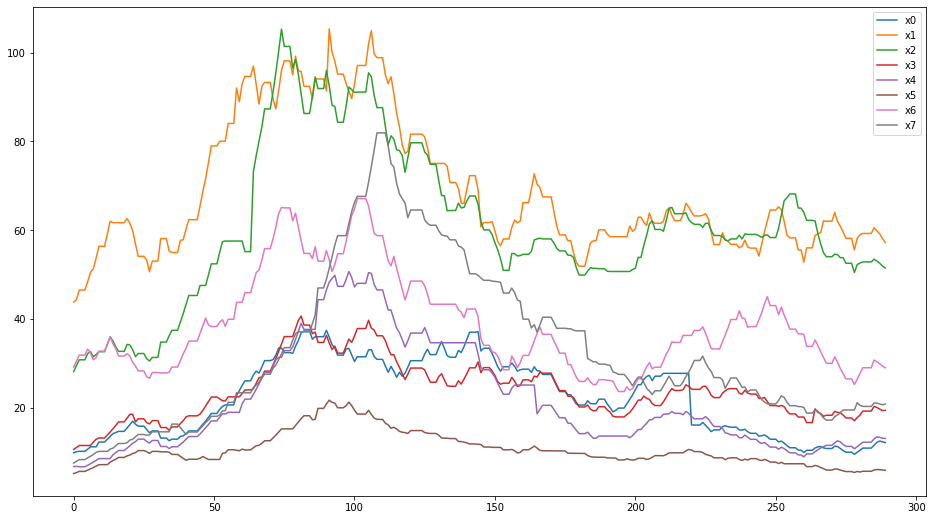

In [5]:
plot_flow(matrix)

In [34]:
import pysindy as ps
dt = 0.01
model = ps.SINDy()
result = model.fit(train, t=dt)

In [37]:
x_test = generate_data_by_model(model, train[0], dt)
steady_state = find_steady_state(x_test)
print('steady_state', steady_state)

steady_state [7.29111856e-304 7.29111856e-304 7.29111856e-304 7.29111856e-304
 7.29111856e-304 7.29111856e-304 7.29111856e-304 7.29111856e-304]


In [38]:
perturbed = future[0]
x_perturbed = apply_perturbation_by_model(model, perturbed, dt)
perturbed_steady_state = find_steady_state(x_perturbed)
print('perturbed_steady_state:', perturbed_steady_state)

perturbed_steady_state: [2.10077583e-312 2.14321575e-312 2.18565567e-312 2.22809558e-312
 2.27053550e-312 2.31297541e-312 2.35541533e-312 2.39785524e-312]


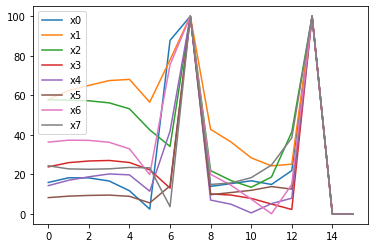

In [39]:
x_flow = flow(x_perturbed, start=1, stop=50)
plot_flow(x_flow)

[0.0, 0.04351239469835683, 0.07416260092120162, 0.09293529461504892, 0.10802374541298594, 0.13665747984563462, 0.30927358409178607, 0.7694150902005625, 0.7253733411330296]


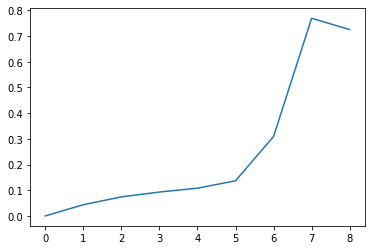

In [42]:
prediction_error_matrix = [flow_prediction_error(x_flow, future, i) for i in range(1,10)]
prediction_error = [sum(error)/number_of_nodes for error in prediction_error_matrix]

print(prediction_error)
plt.figure(1)
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(prediction_error)

In [66]:
degrees = [number_of_nodes-1]*number_of_nodes
g_matrix = calculate_g_by_model(future[0], steady_state, model, 10)
g_dist = find_matrix_dist(g_matrix)
f, _ = calculate_f(g_matrix, degrees)

In [67]:
print(g_matrix)
print(f)

[[1.         0.42039429 0.90606941 1.60585631 3.11499761 1.41527369
  1.05402292 0.97792402]
 [1.         1.         1.         1.         1.         1.
  1.         1.        ]
 [1.1036682  0.46397581 1.         1.77233255 3.43792382 1.56199257
  1.16329159 1.07930365]
 [1.         1.         1.         1.         1.         1.
  1.         1.        ]
 [0.32102753 0.13495814 0.29087323 0.51552409 1.         0.45434182
  0.33837038 0.31394054]
 [1.         1.         1.         1.         1.         1.
  1.         1.        ]
 [0.94874597 0.39884739 0.8596297  1.5235497  2.95534143 1.3427352
  1.         0.92780148]
 [1.         1.         1.         1.         1.         1.
  1.         1.        ]]
[0.93416144 0.52751307 0.98664126 1.09923306 0.5866162  1.00663111
 0.908178   0.7948681 ]


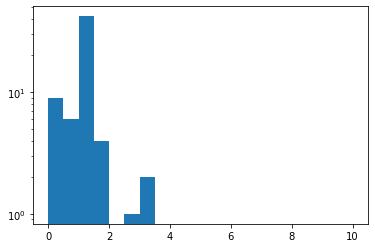

In [68]:
bins=20
_range=(0,10)
plt.rcParams["figure.figsize"] = (6, 4)
plt.figure(2)
plt.hist(g_dist, bins=bins, range=_range, log=True)
plt.show()